# Assignment 1: Comparison of Regression Models on Predicting Medical Costs

### CS 4774 Machine Learning - Department of Computer Science - University of Virginia
![Medical Cost](https://creditkarma-cms.imgix.net/wp-content/uploads/2018/04/boomers-gen-x-high-cost-medical-care.jpg)
In this assignment, you will implement some learning models in the context of a **regression** problem in the [Medical Cost Personal Dataset on Kaggle](https://www.kaggle.com/mirichoi0218/insurance). Specifically, you will attempt to predict the medical cost billed by health insurance using other provided patient's data. For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or the Google Colab if you need additional sample codes to help with your assignment. To get started, you will need to upload/copy the dataset (.csv) into the same folder as this file. 

For deliverables, you must write code in Colab and submit the downloaded Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.


***
##  Task 1: SEE THE BIG PICTURE
Write a paragraph explaining the context of the problem in which you are trying to investigate. We will assume that the data file is put into the same workspace on Colab. Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * Does it contain any categorical data?
 * Is there any missing value?
 * What are some basic statistics you can learn right away about this dataset?

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Sid imports
import sys
import seaborn as sns
from scipy import stats

# to make this notebook's output stable across runs
np.random.seed(42)

# Your code goes here for this section, make sure you also include the output to answer the above questions.
def loadInsuranceData():
  # The column names are adopted from the dataset page on Kaggle   
  insurance_data = pd.read_csv('/content/drive/MyDrive/ML-ColabNotebooks/Assignment01/Data/insurance.csv')
  return insurance_data

Mounted at /content/drive


Before we get any further, lets answer some of the questions posed to us in the intro. Namely, lets get info on the MB size, entries, missing value, and presence of categories (if any)

In [4]:
insurance_data = loadInsuranceData()

insurance_data.info()
insurance_data.memory_usage()
sys.getsizeof(insurance_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


293442

* How big is your dataset? (in terms of MB)
  
We can see that the dataset takes up 293442 bytes which is equivalent to 0.293442 MB. This makes sense in the context of Codeathon01 where we had a wider dataset (~80 features there vs 7 features here). And the data scaling is approximateley 10x as well (2213582 vs 293442 a 7.53x increase)

* How many entries does it have?

We have 1338 entries. 

* How many features does it have?

We have 7 features: 
age, sex, bmi, number of children, smoker, region, and charges (what's this?)

1.   age
2.   sex
3.   bmi
4.   number of children
5.   smoker: basically yes/no smoker or not
6.   region: which region of the US
7.   charges: our label of how much this person was "billed by health insurance"

* Does it contain any categorical data?

I'm going to assume that anything with an object is categorical so yes; sex, smoker, and region. 

* Is there any missing value?

No missing values, our non-null counts are all equivalent to the number of entries. 

Now lets get some basic statistics: 

In [5]:
insurance_data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Lets dive deeper into our label first: 

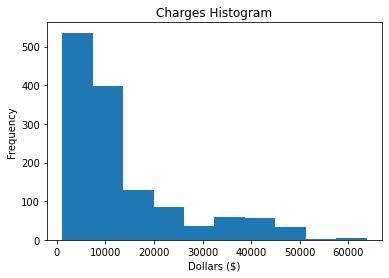

In [6]:
plt.hist(insurance_data['charges'])
plt.title("Charges Histogram")
plt.xlabel("Dollars ($)")
plt.ylabel("Frequency")
plt.show()

So last time our pricing was very easily loggable into a straight line. I don't think doing that here will be any good. This data actually appears to be exponentially distributed so it might be worth trying to normalize it. 

Now lets look at the other non-categorical features: 

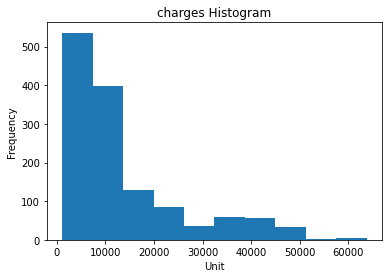

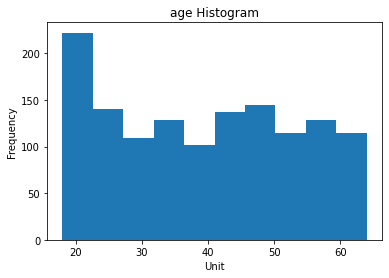

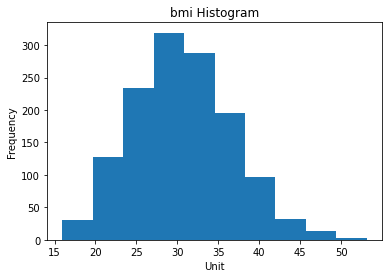

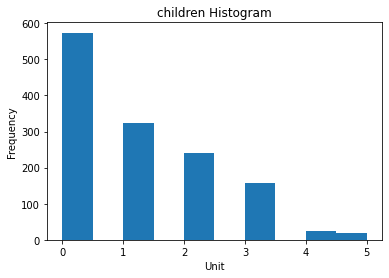

In [7]:
non_categorical_features = ['charges', 'age', 'bmi', 'children']

for i in non_categorical_features: 
  plt.hist(insurance_data[i])
  plt.title(i + " Histogram")
  plt.xlabel("Unit")
  plt.ylabel("Frequency")
  plt.show()

A lot of these make sense, bmi is almost normally distributed, children just goes straight down (kinda funny). Age I have an issue with tho. Shouldn't it be more similar to the US's age distribution? Something like this: 
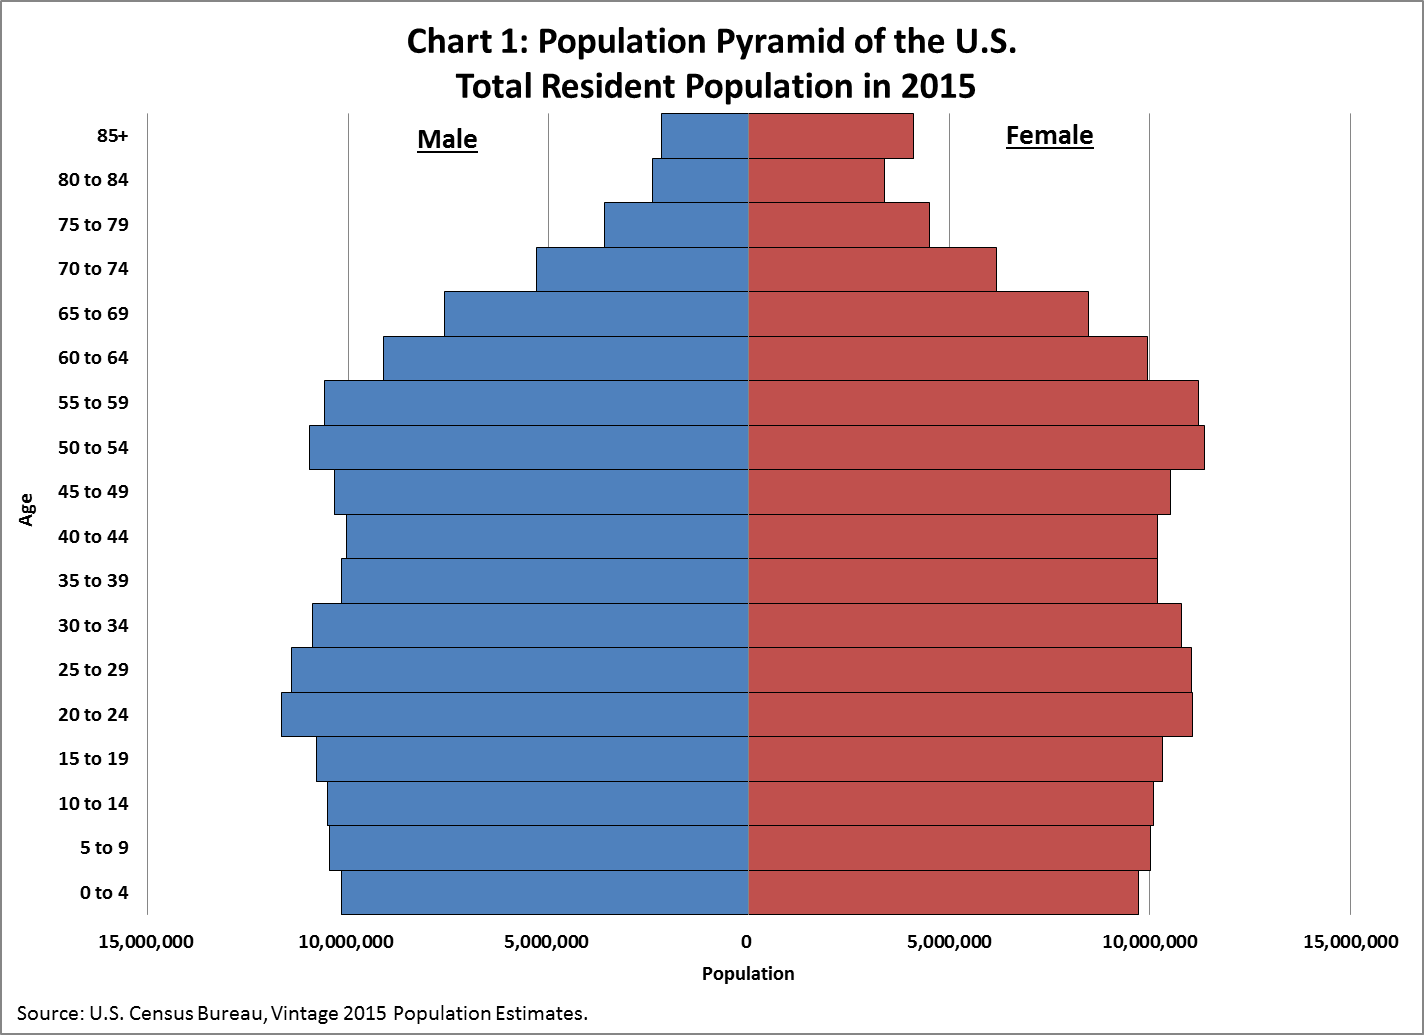

Now lets look at the categorical data: 

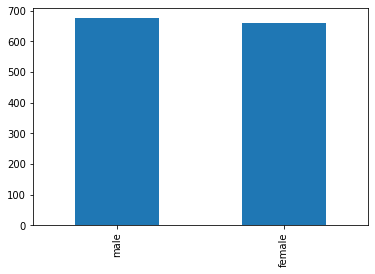

In [8]:
categorical_data_list = ['sex', 'smoker', 'region']

insurance_data['sex'].value_counts().plot(kind='bar')



Nice to see that the genders are balanced, we aren't particularly biased towards one gender over another. 

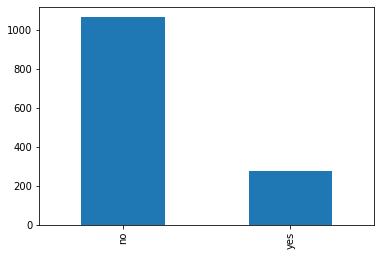

In [9]:
insurance_data['smoker'].value_counts().plot(kind='bar')


I think smokers are over represented here. From the above visual it looks like about 1/5th of people smoke but the real number is closer to 1/8th of people in the US. So we might be skewed towards smokers? Maybe some bias in gathering data? 

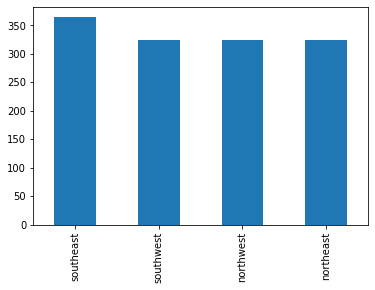

In [10]:
insurance_data['region'].value_counts().plot(kind='bar')

Now lets plot the categorical variables against one another to see if there is some correlation. I know I'm not supposed to do this here but I just found ggplot and wanted to use it. 

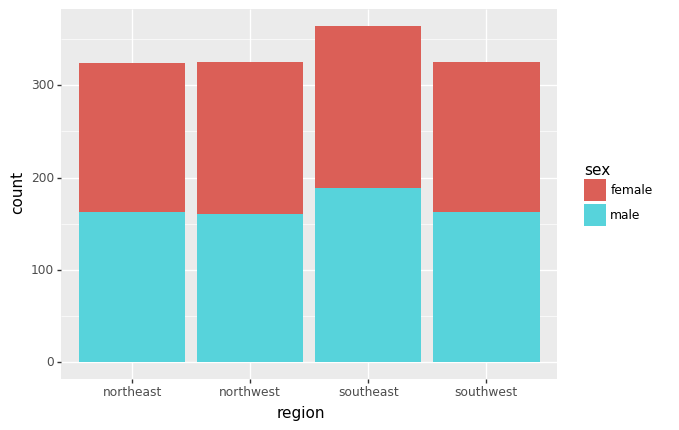

<ggplot: (8732541502369)>

In [11]:
from plotnine import ggplot, aes, geom_bar
ggplot(aes(x = 'region', fill = 'sex'), data = insurance_data) + geom_bar()


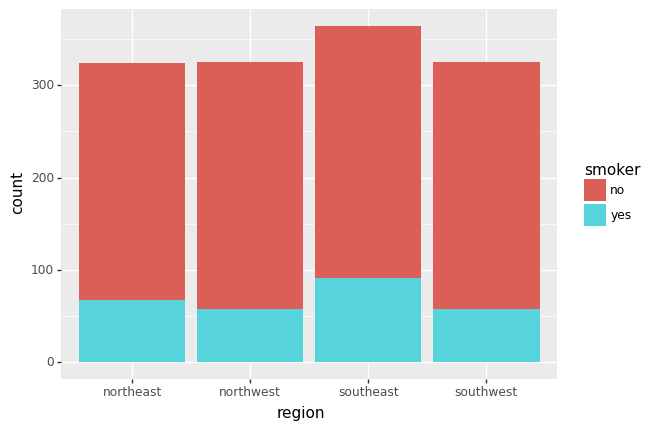

<ggplot: (8732538818981)>

In [12]:
ggplot(aes(x = 'region', fill = 'smoker'), data = insurance_data) + geom_bar()

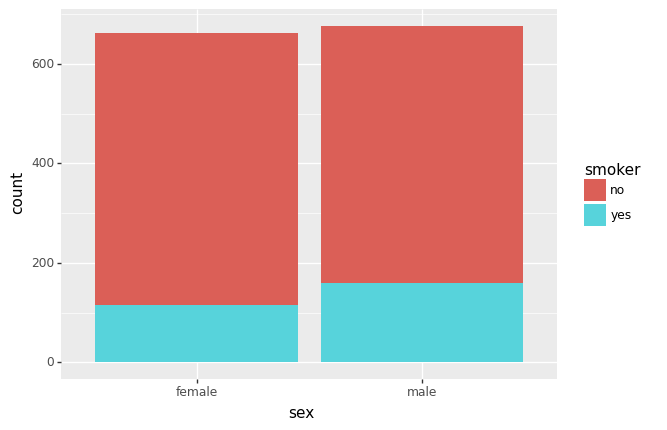

<ggplot: (8732538785457)>

In [13]:
ggplot(aes(x = 'sex', fill = 'smoker'), data = insurance_data) + geom_bar()

I really just wanted to try and see what would happen if we were to plot categorical variables with one another. But I don't notice anything too crazy. They aren't particularly well correlated with one another. 

---
##  Task 2: DATA DISCOVERY, CLEANING, AND SCALING 

**Data Discover:** Plot out all correlations among the features. You should notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class. 

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

**Implementation Note:** You will need to integrate the above operations into a Pipeline to process and transform the training data, then use the same pipeline to transform any validation and testing data.

In [14]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer # sklearn.preprocessing.imputer is deprecated/doesn't exist
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Your code goes here for this section.
# X_train = [];
# y_train = [];
# X_test = [];
# y_test = [];

Before we split our data I want to do some visualization on the overall data: 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f133def7c90>,
      dtype=object)

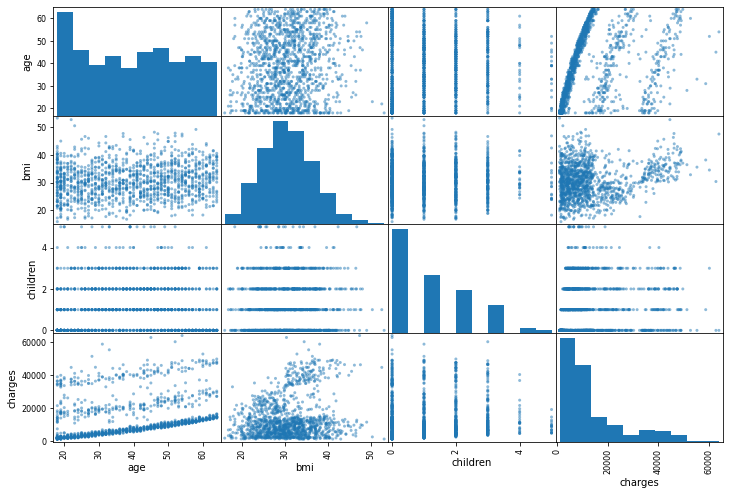

In [15]:
scatter_matrix(insurance_data, figsize = (12,8))

Now lets look at the categorical data: 

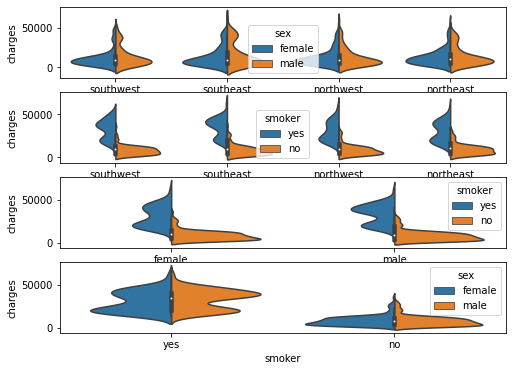

In [16]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(4, 1)

ax = fig.add_subplot(gs[0,0])
sns.violinplot(x ='region', y ='charges', data = insurance_data, hue ='sex', split = True)

ax = fig.add_subplot(gs[1, 0])
sns.violinplot(x ='region', y ='charges', data = insurance_data, hue ='smoker', split = True)

ax = fig.add_subplot(gs[2, 0])
sns.violinplot(x ='sex', y ='charges', data = insurance_data, hue ='smoker', split = True)

ax = fig.add_subplot(gs[3, 0])
sns.violinplot(x ='smoker', y ='charges', data = insurance_data, hue ='sex', split = True)

This data is actually very interesting we can see that at the region level, gender is mostly irrelevant to charges. But at the region level, smokers are penalized extensively. 

In the fourth plot comparing smokers and sex, we can see two distinct humps in the charge distribution. But what is interesting is that female smokers are penalized more often at lower values while men are penalized for smoking more often at higher values. Very interesting. Lets look at smoking/age and make sure age is distributed across sex as well: 

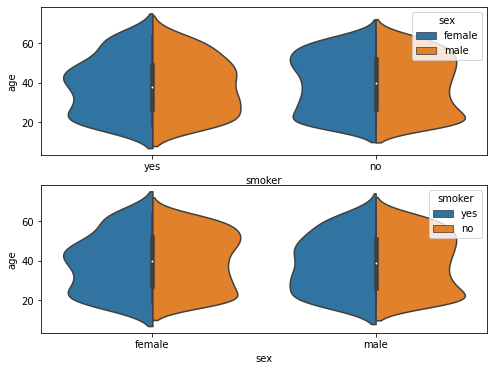

In [17]:
fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(2, 1)

ax = fig.add_subplot(gs[0,0])
sns.violinplot(x ='smoker', y ='age', data = insurance_data, hue ='sex', split = True)

ax = fig.add_subplot(gs[1, 0])
sns.violinplot(x ='sex', y ='age', data = insurance_data, hue ='smoker', split = True)

Huh. No big distributional changes among smoking/non-smoking between ages/sex. Interesting. I thought older people would've smoked more. 

Now lets split the data and then scale/clean it. Here I split across region becuase that seems to be the only relevant categorical feature to split across. If I see some issues with gender/smoking I might split there too. 

In [18]:
from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(insurance_data, insurance_data['region']): 
  strat_train_set = insurance_data.loc[train_index]
  strat_test_set = insurance_data.loc[test_index]

X_train = strat_train_set.drop('charges', axis=1)
y_train = strat_train_set.copy('charges')
X_test = strat_test_set.drop('charges', axis=1)
y_test = strat_test_set.copy('charges')


Now lets onehotencode the categorical columns and then scale/normalize the numerical features. 

In [19]:
from sklearn.compose import ColumnTransformer

non_categorical_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

X_data_transformer = ColumnTransformer( transformers = [('numerical', StandardScaler(), non_categorical_features),
                                                     ('cat', OneHotEncoder(sparse=False), categorical_features)] )

y_data_transformer = ColumnTransformer( transformers = [('numerical', StandardScaler(), ['charges'])] )

In [71]:
X_train_transformed = X_data_transformer.fit_transform(X_train)
y_train_transformed = y_data_transformer.fit_transform(y_train)
X_test_transformed = X_data_transformer.fit_transform(X_test)
y_test_transformed = y_data_transformer.fit_transform(y_test)
# X_data_transformer.get_feature_names_out()

In [23]:
print(pd.DataFrame(X_train_transformed, columns=X_data_transformer.get_feature_names_out())) 

      numerical__age  numerical__bmi  numerical__children  cat__sex_female  \
0           0.472227       -1.756525             0.734336              1.0   
1           0.543313       -1.033082            -0.911192              1.0   
2           0.898745       -0.943687            -0.911192              1.0   
3          -0.025379        0.622393             3.202629              1.0   
4           1.040918       -1.504893             1.557100              1.0   
...              ...             ...                  ...              ...   
1065       -1.518194        0.130717             2.379865              1.0   
1066       -0.025379       -1.107579             3.202629              1.0   
1067        1.325264       -0.891539            -0.911192              0.0   
1068       -0.167551        2.820864             0.734336              1.0   
1069        1.112004       -0.109327            -0.911192              0.0   

      cat__sex_male  cat__smoker_no  cat__smoker_yes  cat__regi

In [24]:
X_train

,age,sex,bmi,children,smoker,region
560,46,female,19.950,2,no,northwest
1285,47,female,24.320,0,no,northeast
1142,52,female,24.860,0,no,southeast
969,39,female,34.320,5,no,southeast
486,54,female,21.470,3,no,northwest
...,...,...,...,...,...,...
1095,18,female,31.350,4,no,northeast
1130,39,female,23.870,5,no,southeast
1294,58,male,25.175,0,no,northeast
860,37,female,47.600,2,yes,southwest


I will implement transforming/scaling the training data later. But looking above we can see how we can retain the transformer labels. Something I couldn't do in codeathon01.

- - -
## Task 3. IMPLEMENT GRADIENT DESCENT 
The gradient descent formulation remain the same as one in the lecture. Keep in mind that you will need to add a column $\textbf{x}_0$ with all 1s as part of the training data. You should write code to implement the **MyLinearRegression** class and its predefined methods. 

**Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code is well-vectorized.

In [89]:
# NOTE: You may not use the library Linear Regression, but implement your own!
# REMEMBER to place self.attribute = [] with value from your implementation

class MyLinearRegression:
  """
  Define what a linear regressor can do
  """

  def __init__ (self):
    """
    Initialize the regressor
    """
    self.theta = []; # parameter vector;
    self.alpha = []; # learning rate
    self.cost  = []; # cost function

  def gradientDescent(self, X_train, y_train, theta, alpha, iters):
    """
    Implementatation of the gradient descent
    INPUT:
    alpha: the learning rate
    iters: number of iterations

    OUTPUT: 
    theta: updated value for theta
    cost: value of the cost function
    """
    # implementation code here
    theta_used = []
    cost_used = []

    # first things first, lets add a column of all 1's to the input a np.ndarray:
    # finding length
    inputLength =  X_train.shape[0]
    # adding 1's
    X_train_ones = np.concatenate( (np.ones((X_train.shape[0], 1)), X_train), axis=1 )
    
    if ( theta.shape != (X_train_ones.shape[0], 1) ):
      theta_used = np.random.rand( X_train_ones.shape[1], 1 )
      print("theta succeeded")
    
    else: 
      theta_used = theta
      print("theta failed")

    m = inputLength + 1 # this is the number of points
    print("M type: " + str(type(m)))

    for iteration in range(iters): 
      # print("X_train_ones type: " + str(X_train_ones.dtype) + " theta type: " + str(theta.dtype) + " y_train type: " + str(y_train.dtype) )
      lost = 1/m * np.sum( (X_train_ones.dot(theta_used) - y_train)**2 )
      cost_used.append(lost)
      gradients = 2/m * X_train_ones.T.dot(X_train_ones.dot(theta_used) - y_train)
      theta_used = theta_used - alpha * gradients

    # loss = 1/m * np.sum( (X_train_ones.dot(theta) - y_train)**2 )

    return theta_used, cost_used

  def fitUsingGradientDescent(self, X_train, y_train):
    """
    Train the regressor using gradient descent
    """
    # implementation code here

    self.theta, self.cost = MyLinearRegression().gradientDescent(X_train, y_train, np.ones((X_train.shape[1] + 1, 1)), 0.1, 100)

  def fitUsingNormalEquation(self, X_train, y_train):
    """
    Training using the Normal (close form) equation
    """
    # implementation code here for Task 4.
    X_train_ones = np.concatenate( (np.ones((X_train.shape[0], 1)), X_train), axis=1 )
    self.theta = np.linalg.inv(X_train_ones.T.dot(X_train_ones)).dot(X_train_ones.T).dot(y_train)

  def predict(self, X_test):
    """
    Predicting the label
    """
    X_test_ones = np.concatenate( (np.ones((X_test.shape[0], 1)), X_test), axis=1 )
    y_predict = X_test_ones.dot(self.theta) 
    return y_predict

  def __str__(self):
    """
    Print out the parameter out when call print()
    """
    
    # implement here to return("Parameter vector is %f" % self.theta)   }
    return("Parameter vector is " + np.array_str(self.theta))
    
# Your code goes here to call the instance of class MyLinearRegression
myGradientDescentModel = MyLinearRegression()
#myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)    

In [42]:
print( MyLinearRegression().gradientDescent(X_train_transformed, y_train_transformed, np.ones((X_train_transformed.shape[1] + 1, 1)), 0.1, 100 ) )

theta succeeded
M type: <class 'int'>
(array([[-0.07059728],
       [ 0.3007824 ],
       [ 0.16990896],
       [ 0.04301204],
       [-0.14677803],
       [-0.14810932],
       [-0.64734847],
       [ 1.31885268],
       [ 0.50114211],
       [ 0.47011319],
       [ 0.44359879],
       [ 0.43034713]]), [9.229305108194657, 3.1011520697123514, 1.3549857961581773, 0.8035703608041395, 0.5963317286915676, 0.49931132948363927, 0.4439917377307595, 0.4078755459208437, 0.38222983349340295, 0.36298928154887317, 0.3479657370868027, 0.3358660724924202, 0.3258811877810376, 0.31748438293342124, 0.3103209973995618, 0.30414412490334014, 0.29877590062003534, 0.2940837296110136, 0.2899654768402248, 0.2863401094136931, 0.2831416877480639, 0.2803154312789036, 0.27781508136023464, 0.2756010846218535, 0.27363930278138515, 0.27190006639855324, 0.2703574583275018, 0.2689887545938929, 0.26777397635363864, 0.2666955227093543, 0.2657378642603607, 0.26488728365438896, 0.26413165350714213, 0.26346024472545515, 0.

* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

theta succeeded
M type: <class 'int'>
theta succeeded
M type: <class 'int'>
theta succeeded
M type: <class 'int'>
theta succeeded
M type: <class 'int'>


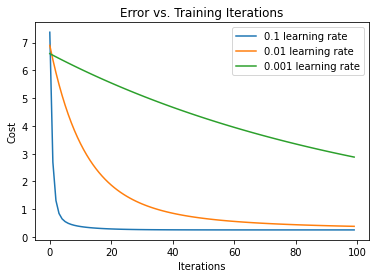

In [97]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You must plot multiple curves corresponding to different learning rates to justify the best one.

theta1, learningRate1 = MyLinearRegression().gradientDescent(X_train_transformed, y_train_transformed, np.ones((X_train_transformed.shape[1] + 1, 1)), 1, 100 )
theta0_1, learningRate0_1 = MyLinearRegression().gradientDescent(X_train_transformed, y_train_transformed, np.ones((X_train_transformed.shape[1] + 1, 1)), 0.1, 100 )
theta0_01, learningRate0_01 = MyLinearRegression().gradientDescent(X_train_transformed, y_train_transformed, np.ones((X_train_transformed.shape[1] + 1, 1)), 0.01, 100 )
theta0_001, learningRate0_001 = MyLinearRegression().gradientDescent(X_train_transformed, y_train_transformed, np.ones((X_train_transformed.shape[1] + 1, 1)), 0.001, 100 )


fig, ax = plt.subplots()

#ax.plot(learningRate1, label = "1 learning rate")
ax.plot(learningRate0_1, label = "0.1 learning rate")
ax.plot(learningRate0_01, label = "0.01 learning rate")
ax.plot(learningRate0_001, label = "0.001 learning rate")


ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Error vs. Training Iterations') 
ax.legend() 

plt.show()

I think the best learning rate is 0.1. I tested out more iterations with smaller learning rates but didn't find any meaningful improvement in final RMSE. Something I want to try is inputting a theta of random values instead of all 1's so we start at a different point and can descend into a (hopefully) global minimum or maybe even a better local minima. 

In [98]:
print(theta0_1)

[[-0.37470225]
 [ 0.30080451]
 [ 0.16980783]
 [ 0.04305993]
 [ 0.11251932]
 [ 0.11133664]
 [-0.45221915]
 [ 1.51308685]
 [ 0.3521126 ]
 [ 0.31810728]
 [ 0.2940051 ]
 [ 0.27985785]]


In [99]:
X_test_ones = np.concatenate( (np.ones((X_test_transformed.shape[0], 1)), X_test_transformed), axis=1 )
y_GD_predict = X_test_ones.dot(theta0_1)

print(y_GD_predict)

[[-3.48060308e-01]
 [-5.19770097e-01]
 [ 1.96526913e+00]
 [-3.09213830e-01]
 [ 1.12870938e+00]
 [-2.17865518e-01]
 [-1.08910311e+00]
 [ 2.96032406e-01]
 [-1.00179813e+00]
 [-1.65029775e-01]
 [ 1.23625073e+00]
 [-3.23512888e-01]
 [-6.69467743e-01]
 [ 2.07989097e+00]
 [ 2.23223437e+00]
 [ 1.97241474e+00]
 [ 1.52337691e-01]
 [ 1.87421043e+00]
 [-3.44113320e-01]
 [ 1.51204691e+00]
 [-7.76297512e-01]
 [-2.64380840e-01]
 [-9.15846323e-01]
 [-5.23973674e-01]
 [-1.57640180e-01]
 [-2.55381208e-02]
 [ 9.69759317e-02]
 [-5.92526006e-01]
 [-2.66458533e-01]
 [-9.30294288e-01]
 [-3.42803188e-01]
 [-1.78600628e-02]
 [-7.36779201e-01]
 [-8.09656840e-01]
 [-7.38484426e-01]
 [-2.87701273e-02]
 [-9.42317696e-01]
 [-3.73104954e-01]
 [ 1.66904938e+00]
 [ 1.59705301e+00]
 [-7.77829733e-01]
 [-7.50148316e-01]
 [ 6.66069664e-02]
 [-1.47567364e-01]
 [-3.81086024e-01]
 [-9.37127484e-02]
 [-6.71969863e-01]
 [-8.38480024e-01]
 [ 1.84305170e+00]
 [-3.53039047e-01]
 [ 2.08237847e-01]
 [-9.13986790e-01]
 [-8.8862652

- - -
## Task 4. IMPLEMENT THE NORMAL EQUATION

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement: 

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [90]:
# Implement the normalEquation method of the MyLinearRegression Class before execute the code below:
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train_transformed, y_train_transformed)
print(myNormalEquationModel)


Parameter vector is [[-8.37210524e+14]
 [ 2.47059098e-01]
 [ 1.28533461e-01]
 [ 1.77194206e-02]
 [-8.37210524e+14]
 [-8.37210524e+14]
 [ 1.67442105e+15]
 [ 1.67442105e+15]
 [ 1.10584567e+00]
 [ 1.02552882e+00]
 [ 1.11726948e+00]
 [ 6.83824923e-01]]


In [100]:
y_NE_predict = myNormalEquationModel.predict(X_test_transformed)
print(y_NE_predict)

[[-0.12212533]
 [-0.28664477]
 [ 2.25      ]
 [-0.25      ]
 [ 1.25      ]
 [-0.625     ]
 [-0.83798515]
 [ 0.375     ]
 [-0.70398083]
 [-0.25      ]
 [ 1.125     ]
 [-0.375     ]
 [-0.42099737]
 [ 2.125     ]
 [ 2.375     ]
 [ 2.        ]
 [ 0.19877828]
 [ 2.25      ]
 [-0.11965699]
 [ 1.75      ]
 [-1.125     ]
 [-0.5       ]
 [-1.125     ]
 [-0.31033626]
 [ 0.00729057]
 [ 0.00689268]
 [-0.20292697]
 [-0.40040522]
 [-0.08667353]
 [-0.75      ]
 [-0.49641481]
 [ 0.08559922]
 [-0.57806216]
 [-0.59722751]
 [-1.        ]
 [ 0.125     ]
 [-0.87897968]
 [-0.48900978]
 [ 1.75      ]
 [ 1.875     ]
 [-0.85340123]
 [-0.625     ]
 [-0.25857303]
 [ 0.        ]
 [-0.5       ]
 [-0.375     ]
 [-0.52201821]
 [-1.02756094]
 [ 2.        ]
 [-0.25      ]
 [ 0.16642582]
 [-0.75      ]
 [ 0.04951641]
 [-0.625     ]
 [-0.125     ]
 [ 0.        ]
 [-0.375     ]
 [ 1.625     ]
 [-0.23837878]
 [-0.01083323]
 [-0.14974926]
 [-0.1380139 ]
 [-0.25      ]
 [-0.14977422]
 [-0.02855913]
 [-0.41319445]
 [ 1.     

- - -
## Task 5. COMPARE DIFFERENT IMPLEMENTATIONS 

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you must use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the RMSE on the **test set** as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [168]:
from sklearn.metrics import mean_squared_error

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
mySGDModel = SGDRegressor()
mySGDModel.fit(X_train_transformed,y_train_transformed)
y_SGD_predict = np.reshape(mySGDModel.predict(X_test_transformed), (-1, 1))

mse = mean_squared_error(y_data_transformer.named_transformers_['numerical'].inverse_transform(y_test_transformed), y_data_transformer.named_transformers_['numerical'].inverse_transform(y_SGD_predict))
mySGDModel_rmse = np.sqrt(mse)
print("RMSE for SGD Model: ")
print(mySGDModel_rmse)

# for the gradient descent method:
mse = mean_squared_error(y_data_transformer.named_transformers_['numerical'].inverse_transform(y_test_transformed), y_data_transformer.named_transformers_['numerical'].inverse_transform(y_GD_predict))
myGradientDescentModel_rmse = np.sqrt(mse) 

print("RMSE for Gradient Descent Model: ")
print(myGradientDescentModel_rmse) 


# for the normal equation
mse = mean_squared_error(y_data_transformer.named_transformers_['numerical'].inverse_transform(y_test_transformed), y_data_transformer.named_transformers_['numerical'].inverse_transform(y_NE_predict))
myNormalEquationModel_rmse = np.sqrt(mse)

print("RMSE for Normal Equation Model: ")
print(myNormalEquationModel_rmse) 



RMSE for SGD Model: 
5789.071448282772
RMSE for Gradient Descent Model: 
5782.388966609531
RMSE for Normal Equation Model: 
6083.491424385476


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


- - -
## Task 6. PRESENT YOUR SOLUTION 

Now that you need to write a short memo of one paragraph to be read by a non-technical audience (ie. your manager/boss). Focus on answering the following: 

* How can you pitch your solution to this project? 
* What did you learn so far about the problem?
* Is there any insight moving forward to improve the solution.

My solution to this project isn't too pitchable, I merely implemented an established method of minimizing error. But I found that my Gradient Descent Model performed (slightly) better than the SGD Regressor and significantly better than Normal Equation method. 

I found that implementing these things was very useful due to the exposure it gave to the underlying processes within most ML algos. Gradient descent was introduced to me in Multivariable Calculus but implementing it in python and viewing the results is invaluable. Lets actually look at the thetas for the two models and look at which features are/aren't important. Before we look at them I'll make a couple guesses: 
*   Being a smoker will result in more medical costs
*   Having more children (especially for women) will result in more medical costs
*   Older people will have higher medical costs



In [118]:
print(myNormalEquationModel)
print(theta0_1)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=X_data_transformer.get_feature_names_out())
print(X_train_transformed_df.info()) 


Parameter vector is [[-8.37210524e+14]
 [ 2.47059098e-01]
 [ 1.28533461e-01]
 [ 1.77194206e-02]
 [-8.37210524e+14]
 [-8.37210524e+14]
 [ 1.67442105e+15]
 [ 1.67442105e+15]
 [ 1.10584567e+00]
 [ 1.02552882e+00]
 [ 1.11726948e+00]
 [ 6.83824923e-01]]
[[-0.37470225]
 [ 0.30080451]
 [ 0.16980783]
 [ 0.04305993]
 [ 0.11251932]
 [ 0.11133664]
 [-0.45221915]
 [ 1.51308685]
 [ 0.3521126 ]
 [ 0.31810728]
 [ 0.2940051 ]
 [ 0.27985785]]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   numerical__age         1070 non-null   float64
 1   numerical__bmi         1070 non-null   float64
 2   numerical__children    1070 non-null   float64
 3   cat__sex_female        1070 non-null   float64
 4   cat__sex_male          1070 non-null   float64
 5   cat__smoker_no         1070 non-null   float64
 6   cat__smoker_yes        1070 non-null   flo

Ok that's a little ugly how about we plot the theta's with relative importance between the two and the column names as the labels? 

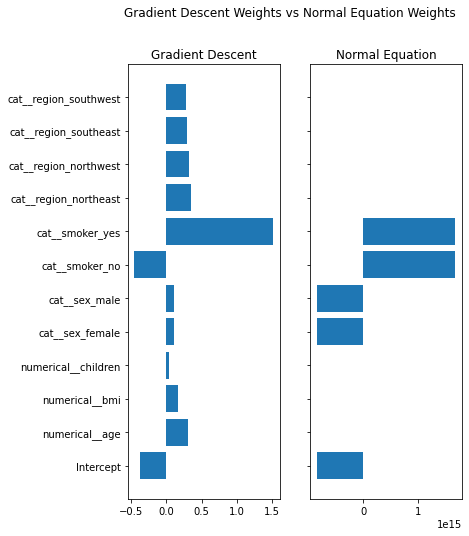

In [165]:
# fig = plt.figure()
columns = ['Intercept'] + list(X_train_transformed_df)
# print(columns)
# print(myNormalEquationModel.theta.T.tolist())
# print(theta0_1.T.tolist())
# ax = fig.add_axes([0, 0, 1, 1])
# #ax.bar(myNormalEquationModel.theta.T.tolist()[0], columns)
# ax.barh(columns, theta0_1.T.tolist()[0])
# ax.barh(columns, myNormalEquationModel.theta.T.tolist()[0], height=0.8, label='billybob')
# plt.show()
fig, (ax1, ax2) = plt.subplots(
    1, 2, sharex=False, sharey=True, figsize=(6,8), frameon=False
)

ax1.barh(columns, theta0_1.T.tolist()[0])
ax1.set_title("Gradient Descent")
ax2.barh(columns, myNormalEquationModel.theta.T.tolist()[0], height=0.8, label='billybob')
ax2.set_title("Normal Equation")

fig.suptitle("Gradient Descent Weights vs Normal Equation Weights")
plt.show()

Ok so in Gradient Descent we can see how being a smoker increases your costs while not being a smoker decreases your costs. Interestingly, having children doesn't significantly increase your costs, only a slight bias (recall that the children value was standard scaled). Another interesting thing is that being older is worse than having a high bmi which is surprising. I would've thought that a high bmi would be worse than being old but I can see how old people would go to the doctor more often/have more expensive procedures. 

Another thing to notice is that each of the regions has their own bias. Interestingly the northeast is the most expensive. With the south having significantly lower costs. 

I'm not going to bother analyzing the Normal Equation results. For some reason almost all the weight is placed on gender and whether or not one is a smoker? This may be an artifact of these values being one-hot encoded. I want to do more analysis on this. 

Some of the things we can learn about the problem is that if you want insurance, you shouldn't smoke becuase smoking will make you pay massive health insurance costs. If we interpret health insurance cost as a proxy for overall health where less insurance costs represents a healthier person, its interesting to see how relatively poor BMI is at predicting health. BMI is almost useless, a worse predictor than age and region. 

Moving forward I want to use regressor trees to break the data down along the binary values (sex, smoker, and region) so that we can check and see if our regression assigns greater weight to some numerical values than others. For example, assigning a high insurance charge to women that have children as opposed to men that have children. 

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit?usp=sharing) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](http://bit.ly/cs4774oh)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS4774 Assignment 1:...".

Best of luck and have fun!